<img src="https://static.wixstatic.com/media/66c28f_db7a1ba3e35b4b17a6688472c889b7bf~mv2_d_2777_1254_s_2.png/v1/fill/w_710,h_320,al_c,q_85,usm_0.66_1.00_0.01/logo_yellow_white.webp" width=1000, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

# Text Summarization

Всем привет! Сегодня мы познакомимся с задачей суммаризации текста на примере генерации "сжатых" новостей. Рассмотрим некоторые базовые решения и познакомимся с архитектурами нейросетей для решения задачи.
Датасет: gazeta.ru


`Ноутбук создан на основе семинара Гусева Ильи на кафедре компьютерной лингвистики ABBYY МФТИ.`

Загрузим датасет и необходимые библиотеки

In [1]:
!wget -q https://www.dropbox.com/s/43l702z5a5i2w8j/gazeta_train.txt
!wget -q https://www.dropbox.com/s/k2egt3sug0hb185/gazeta_val.txt
!wget -q https://www.dropbox.com/s/3gki5n5djs9w0v6/gazeta_test.txt

In [2]:
!pip -q install razdel networkx pymorphy2 nltk rouge==0.3.1 summa 

     |████████████████████████████████| 55 kB 122 kB/s 
     |████████████████████████████████| 54 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 37.4 MB/s 


## Dataset

Посмотрим на то, как устроен датасет

In [3]:
!head -n 1 gazeta_train.txt
!cat gazeta_train.txt | wc -l
!cat gazeta_val.txt | wc -l
!cat gazeta_test.txt | wc -l

{"url": "https://www.gazeta.ru/financial/2011/11/30/3852658.shtml", "text": "«По итогам 2011 года чистый отток может составить примерно $80 млрд, в следующем году — около $20 млрд. При этом мы ожидаем, что со второго полугодия 2012 года начнется приток капитала», — заявил «Интерфаксу» замминистра экономического развития Андрей Клепач. Официальные прогнозы по выводу капитала из России становятся все пессимистичными: еще летом власти полагали, что из страны уйдет не более $35 млрд, в сентябре Минэкономразвития назвал цифру $50 млрд, в начале ноября Центробанк пересмотрел оценку до $70 млрд. Очередное изменение прогноза было ожидаемо: по расчетам Центробанка , за январь — октябрь чистый отток капитала достиг $64 млрд, причем в последние месяцы он ускорился: в сентябре он составил $14 млрд, в октябре — $13 млрд против среднего ежемесячного оттока в $6—8 млрд в первом полугодии. «После октябрьских данных Минэкономразвития вынуждено было изменить оценку, настаивать на $70 млрд означало ожида

In [4]:
import json
import random

def read_gazeta_records(file_name, shuffle=True, sort_by_date=False):
    assert shuffle != sort_by_date
    records = []
    with open(file_name, "r") as r:
        for line in r:
            records.append(json.loads(line))
    if sort_by_date:
        records.sort(key=lambda x: x["date"])
    if shuffle:
        random.shuffle
    return records

In [5]:
train_records = read_gazeta_records("gazeta_train.txt")
val_records = read_gazeta_records("gazeta_val.txt")
test_records = read_gazeta_records("gazeta_test.txt")

In [143]:
from nltk.translate.bleu_score import corpus_bleu
from rouge import Rouge

def calc_scores(references, predictions, metric="all"):
    print("Count:", len(predictions))
    print("Ref[-1]:", references[-1])
    print("Hyp[-1]:", predictions[-1])
    print("Ref[-2]:", references[-2])
    print("Hyp[-2]:", predictions[-2])
    print("Ref[-3]:", references[-3])
    print("Hyp[-3]:", predictions[-3])


    if metric in ("bleu", "all"):
        print("BLEU: ", corpus_bleu([[r] for r in references], predictions))
    if metric in ("rouge", "all"):
        rouge = Rouge()
        scores = rouge.get_scores(predictions, references, avg=True)
        print("ROUGE: ", scores)

    return corpus_bleu([[r] for r in references], predictions)

## Extractive RNN

### BPE
Для начала сделаем BPE токенизацию

In [7]:
!pip install youtokentome

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.2 MB/s 


In [8]:
import youtokentome as yttm

def train_bpe(records, model_path, model_type="bpe", vocab_size=10000, lower=True):
    temp_file_name = "temp.txt"
    with open(temp_file_name, "w") as temp:
        for record in records:
            text, summary = record['text'], record['summary']
            if lower:
                summary = summary.lower()
                text = text.lower()
            if not text or not summary:
                continue
            temp.write(text + "\n")
            temp.write(summary + "\n")
    yttm.BPE.train(data=temp_file_name, vocab_size=vocab_size, model=model_path)

train_bpe(train_records, "BPE_model.bin")

### Словарь
Составим словарь для индексации токенов

In [9]:
bpe_processor = yttm.BPE('BPE_model.bin')
vocabulary = bpe_processor.vocab()

### Кэш oracle summary
Закэшируем oracle summary, чтобы не пересчитывать их каждый раз

In [40]:
from rouge import Rouge
import razdel
from tqdm.notebook import tqdm

import copy

def build_oracle_summary_greedy(text, gold_summary, calc_score, lower=True, max_sentences=30):
    '''
    Жадное построение oracle summary
    '''
    gold_summary = gold_summary.lower() if lower else gold_summary
    # Делим текст на предложения
    sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
    n_sentences = len(sentences)
    oracle_summary_sentences = set()
    
    score = -1.0
    summaries = []
    for _ in range(n_sentences):
        for i in range(n_sentences):
            if i in oracle_summary_sentences:
                continue
            current_summary_sentences = copy.copy(oracle_summary_sentences)
            # Добавляем какое-то предложения к уже существующему summary
            current_summary_sentences.add(i)
            current_summary = " ".join([sentences[index] for index in sorted(list(current_summary_sentences))])
            # Считаем метрики
            current_score = calc_score(current_summary, gold_summary)
            summaries.append((current_score, current_summary_sentences))
        # Если получилось улучшить метрики с добавлением какого-либо предложения, то пробуем добавить ещё
        # Иначе на этом заканчиваем
        best_summary_score, best_summary_sentences = max(summaries)
        if best_summary_score <= score:
            break
        oracle_summary_sentences = best_summary_sentences
        score = best_summary_score
    oracle_summary = " ".join([sentences[index] for index in sorted(list(oracle_summary_sentences))])
    return oracle_summary, oracle_summary_sentences

def calc_single_score(pred_summary, gold_summary, rouge):
    return rouge.get_scores([pred_summary], [gold_summary], avg=True)['rouge-2']['f']

def add_oracle_summary_to_records(records, max_sentences=30, lower=True, nrows=1000):
    rouge = Rouge()
    for i, record in tqdm(enumerate(records)):
        if i >= nrows:
            break
        text = record["text"]
        summary = record["summary"]

        summary = summary.lower() if lower else summary
        sentences = [sentence.text.lower() if lower else sentence.text for sentence in razdel.sentenize(text)][:max_sentences]
        oracle_summary, sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=lambda x, y: calc_single_score(x, y, rouge),
                                                                         lower=lower, max_sentences=max_sentences)
        record["sentences"] = sentences
        record["oracle_sentences"] = list(sentences_indicies)
        record["oracle_summary"] = oracle_summary

    return records[:nrows]

ext_train_records = add_oracle_summary_to_records(train_records, nrows=2048)
ext_val_records = add_oracle_summary_to_records(val_records, nrows=256)
ext_test_records = add_oracle_summary_to_records(test_records, nrows=256)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Составление батчей

In [41]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [42]:
import random
import math
import razdel
import torch
import numpy as np
from rouge import Rouge


class BatchIterator():
    def __init__(self, records, vocabulary, batch_size, bpe_processor, shuffle=True, lower=True, max_sentences=30, max_sentence_length=50, device=torch.device('cpu')):
        self.records = records
        self.num_samples = len(records)
        self.batch_size = batch_size
        self.bpe_processor = bpe_processor
        self.shuffle = shuffle
        self.batches_count = int(math.ceil(self.num_samples / batch_size))
        self.lower = lower
        self.rouge = Rouge()
        self.vocabulary = vocabulary
        self.max_sentences = max_sentences
        self.max_sentence_length = max_sentence_length
        self.device = device
        
    def __len__(self):
        return self.batches_count
    
    def __iter__(self):
        indices = np.arange(self.num_samples)
        if self.shuffle:
            np.random.shuffle(indices)

        for start in range(0, self.num_samples, self.batch_size):
            end = min(start + self.batch_size, self.num_samples)
            batch_indices = indices[start:end]

            batch_inputs = []
            batch_outputs = []
            max_sentence_length = 0
            max_sentences = 0
            batch_records = []

            for data_ind in batch_indices:
                
                record = self.records[data_ind]
                batch_records.append(record)
                text = record["text"]
                summary = record["summary"]
                summary = summary.lower() if self.lower else summary

                if "sentences" not in record:
                    sentences = [sentence.text.lower() if self.lower else sentence.text for sentence in razdel.sentenize(text)][:self.max_sentences]
                else:
                    sentences = record["sentences"]
                max_sentences = max(len(sentences), max_sentences)
                
                # номера предложений, которые в нашем саммари
                if "oracle_sentences" not in record:
                    calc_score = lambda x, y: calc_single_score(x, y, self.rouge)
                    sentences_indicies = build_oracle_summary_greedy(text, summary, calc_score=calc_score, lower=self.lower, max_sentences=self.max_sentences)[1]
                else:   
                    sentences_indicies = record["oracle_sentences"]
                
                # inputs - индексы слов в предложении
                inputs = [bpe_processor.encode(sentence)[:self.max_sentence_length] for sentence in sentences]
                max_sentence_length = max(max_sentence_length, max([len(tokens) for tokens in inputs]))
                
                # получение метки класса предложения
                outputs = [int(i in sentences_indicies) for i in range(len(sentences))]
                batch_inputs.append(inputs)
                batch_outputs.append(outputs)

            tensor_inputs = torch.zeros((self.batch_size, max_sentences, max_sentence_length), dtype=torch.long, device=self.device)
            # we add index 2 for padding
            # YOUR CODE
            tensor_outputs = torch.ones((self.batch_size, max_sentences), dtype=torch.float32, device=self.device) * 2

            for i, inputs in enumerate(batch_inputs):
                for j, sentence_tokens in enumerate(inputs):
                    tensor_inputs[i][j][:len(sentence_tokens)] = torch.tensor(sentence_tokens, dtype=torch.int64)

            for i, outputs in enumerate(batch_outputs):
                tensor_outputs[i][:len(outputs)] = torch.LongTensor(outputs)

            tensor_outputs = tensor_outputs.long()
            yield {
                'inputs': tensor_inputs,
                'outputs': tensor_outputs,
                'records': batch_records
            }            

In [43]:
train_iterator = BatchIterator(ext_train_records, vocabulary, 32, bpe_processor, device=device)
val_iterator = BatchIterator(ext_val_records, vocabulary, 32, bpe_processor, device=device)
test_iterator = BatchIterator(ext_test_records, vocabulary, 32, bpe_processor, device=device)

## Extractor -  SummaRuNNer
 https://arxiv.org/pdf/1611.04230.pdf


### Homework

* В данной реализации в `outputs` в качестве padding используется индекс 0. Измените в функции \_\_iter__ индекс padding, чтобы он не совпадал с классом 0 или 1, например, 2.
* В качестве criterion используйте `CrossEntropyLoss`вместо `BCEWithLogitsLoss`
* Из-за смены criterion, вы уже должны подавать на вход criterion ни одно число, а logits для каждого класса. Перед подачей logits вы можете отфильтровать предсказания для класса padding. В этом пункте вам придется изменять файл `train_model.py`, а именно функциии `train` и `evaluate`.
* Используйте два варианта обучения: c весами в `CrossEntropyLoss` и без
* Также сравните `inference`, когда вы ранжируете logits, и когды вы выбирате предложения, у котрых logits > 0, в двух вариантах обучения. 
* Реализуйте дополнительно характеристику предложения `novelty`. Как влияет добавление `novelty` на качество summary?
* Постарайтесь улучшить качество модели, полученной на семинаре: $BLEU \approx 0.45$

In [59]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack

class SentenceEncoderRNN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, n_layers=3, dropout=0.3, bidirectional=True):
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.embedding_dim = embedding_dim
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding_layer = nn.Embedding(input_size, embedding_dim)
        self.rnn_layer = nn.LSTM(embedding_dim, hidden_size, n_layers, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, inputs, hidden=None):
        embedded = self.dropout_layer(self.embedding_layer(inputs))
        outputs, _ = self.rnn_layer(embedded, hidden)
        sentences_embeddings = torch.mean(outputs, 1)
        # [batch_size, hidden_size]
        return sentences_embeddings

class SentenceTaggerRNN(nn.Module):
    def __init__(self,
                 vocabulary_size,
                 use_content=True,
                 use_salience=True,
                 use_novelty=True,
                 token_embedding_dim=128,
                 sentence_encoder_hidden_size=256,
                 hidden_size=256,
                 bidirectional=True,
                 sentence_encoder_n_layers=2,
                 sentence_encoder_dropout=0.3,
                 sentence_encoder_bidirectional=True,
                 n_layers=2,
                 dropout=0.3):
      
        super().__init__()

        num_directions = 2 if bidirectional else 1
        assert hidden_size % num_directions == 0
        hidden_size = hidden_size // num_directions

        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.sentence_encoder = SentenceEncoderRNN(vocabulary_size, token_embedding_dim,
                                                   sentence_encoder_hidden_size, sentence_encoder_n_layers, 
                                                   sentence_encoder_dropout, sentence_encoder_bidirectional)
        
        self.rnn_layer = nn.LSTM(sentence_encoder_hidden_size, hidden_size, n_layers, dropout=dropout,
                           bidirectional=bidirectional, batch_first=True)
        
        self.dropout_layer = nn.Dropout(dropout)
        self.content_linear_layer = nn.Linear(hidden_size * 2, 1)
        self.document_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.salience_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.novelty_linear_layer = nn.Linear(hidden_size * 2, hidden_size * 2)
        self.tanh_layer = nn.Tanh()

        self.use_content = use_content
        self.use_salience = use_salience
        self.use_novelty = use_novelty

    def forward(self, inputs, hidden=None):
        # parameters of the probability
        content = 0
        salience = 0
        novelty = 0

        # [batch_size, seq num, seq_len]
        batch_size = inputs.size(0)
        sentences_count = inputs.size(1)
        tokens_count = inputs.size(2)
        inputs = inputs.reshape(-1, tokens_count)
        # [batch_size * seq num, seq_len]

        embedded_sentences = self.sentence_encoder(inputs)
        embedded_sentences = self.dropout_layer(embedded_sentences.reshape(batch_size, sentences_count, -1))
        # [batch_size *  seq num, seq_len, hidden_size] -> [batch_size, seq num, hidden_size]

        outputs, _ = self.rnn_layer(embedded_sentences, hidden)
        # [batch_size, seq num, hidden_size]

        document_embedding = self.tanh_layer(self.document_linear_layer(torch.mean(outputs, 1)))
        # [batch_size, hidden_size]

        # W * h^T
        if self.use_content:
            content = self.content_linear_layer(outputs).squeeze(2) # 1-representation
        # [batch_size, seq num]

        # h^T * W * d
        if self.use_salience:
            salience = torch.bmm(outputs, self.salience_linear_layer(document_embedding).unsqueeze(2)).squeeze(2) # 2-representation
        # [batch_size, seq num, hidden_size] * [batch_size, hidden_size, 1] = [batch_size, seq num, ]

        if self.use_novelty:
            # at every step add novelty to prediction of the sentence
            predictions = content + salience
            
            # 0) initialize summary_representation and novelty by zeros
            # YOUR CODE

            summary_representation = torch.zeros((batch_size, self.hidden_size*2)).to(device)
            novelty = torch.zeros((batch_size, sentences_count)).to(device)
            
            for sentence_num in range(sentences_count):

                # 1) take sentence_num_state from outputs(representation of the sentence with number sentence_num)
                # 2) calculate novelty for current sentence
                # 3) add novelty to predictions
                # 4) calculcate probability for current sentence
                # 5) add sentence_num_state with the weight which is equal to probability to summary_representation

                # YOUR CODE

                sentence_num_state = outputs[:, sentence_num, :]
                novelty_intermediate = self.novelty_linear_layer(torch.tanh(summary_representation)).unsqueeze(2)

                novelty[:, sentence_num] = -torch.bmm(sentence_num_state.unsqueeze(1), \
                                                      novelty_intermediate).squeeze(2).squeeze(1)
                predictions[:, sentence_num] += novelty[:, sentence_num]
                probabilities = torch.sigmoid(predictions[:, sentence_num])
                summary_representation += torch.mv(sentence_num_state.transpose(0, 1), probabilities)

            return predictions
        
        return content + salience + novelty

## Model
$P\left(y_{j} = 1 \mid \mathbf{h}_{j}, \mathbf{s}_{j}, \mathbf{d}\right)=\sigma\left(W_{c} \mathbf{h}_{j} + \mathbf{h}_{j}^{T} W_{s} \mathbf{d}\right)$
--------------------

In [60]:
vocab_size = len(vocabulary)
model = SentenceTaggerRNN(vocab_size).to(device)

params_count = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
print("Trainable params: {}".format(params_count))

Trainable params: 2927617


In [61]:
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()}")

sentence_encoder.embedding_layer.weight: 1280000
sentence_encoder.rnn_layer.weight_ih_l0: 65536
sentence_encoder.rnn_layer.weight_hh_l0: 65536
sentence_encoder.rnn_layer.bias_ih_l0: 512
sentence_encoder.rnn_layer.bias_hh_l0: 512
sentence_encoder.rnn_layer.weight_ih_l0_reverse: 65536
sentence_encoder.rnn_layer.weight_hh_l0_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l0_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l0_reverse: 512
sentence_encoder.rnn_layer.weight_ih_l1: 131072
sentence_encoder.rnn_layer.weight_hh_l1: 65536
sentence_encoder.rnn_layer.bias_ih_l1: 512
sentence_encoder.rnn_layer.bias_hh_l1: 512
sentence_encoder.rnn_layer.weight_ih_l1_reverse: 131072
sentence_encoder.rnn_layer.weight_hh_l1_reverse: 65536
sentence_encoder.rnn_layer.bias_ih_l1_reverse: 512
sentence_encoder.rnn_layer.bias_hh_l1_reverse: 512
rnn_layer.weight_ih_l0: 131072
rnn_layer.weight_hh_l0: 65536
rnn_layer.bias_ih_l0: 512
rnn_layer.bias_hh_l0: 512
rnn_layer.weight_ih_l0_reverse: 131072
rnn_layer.wei

In [62]:
#!gdown https://drive.google.com/uc?id=1MiS_iczALcyF7zGDPY6niyeD82P0_PBH -O train_model.py


In [63]:
#import train_model
#import imp 
#imp.reload(train_model)
#from train_model import train_with_logs

In [287]:
import matplotlib
import time
import math
import torch
import re
import razdel
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
from IPython.display import clear_output

def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # YOUR CODE
        model.train()
        logits = model(batch["inputs"])
        target = batch["outputs"]
        prob = torch.sigmoid(logits)
        input = torch.cat([(1-prob).unsqueeze(-1), prob.unsqueeze(-1)], dim=2)
        input = input.view(-1,2)
        target = target.view(-1,1)[:,0]
        loss = criterion(input, target)
    
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.item())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    
    epoch_loss = 0
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            model.eval()
            logits = model(batch["inputs"])
            target = batch["outputs"]
            prob = torch.sigmoid(logits)
            input = torch.cat([(1-prob).unsqueeze(-1), prob.unsqueeze(-1)], dim=2)
            input = input.view(-1,2)
            target = target.view(-1,1)[:,0]
            loss = criterion(input, target)
            
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train_with_logs(model, train_iterator, valid_iterator, optimizer, criterion, N_EPOCHS, CLIP):
    train_history = []
    valid_history = []
    
    best_valid_loss = float('inf')
    
    for epoch in range(N_EPOCHS):
        
        start_time = time.time()
        
        train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
        valid_loss = evaluate(model, valid_iterator, criterion)
        
        end_time = time.time()
        
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'best-val-model.pt')
        
        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
def punct_detokenize(text):
    text = text.strip()
    punctuation = ",.!?:;%"
    closing_punctuation = ")]}"
    opening_punctuation = "([}"
    for ch in punctuation + closing_punctuation:
        text = text.replace(" " + ch, ch)
    for ch in opening_punctuation:
        text = text.replace(ch + " ", ch)
    res = [r'"\s[^"]+\s"', r"'\s[^']+\s'"]
    for r in res:
        for f in re.findall(r, text, re.U):
            text = text.replace(f, f[0] + f[2:-2] + f[-1])
    text = text.replace("' s", "'s").replace(" 's", "'s")
    text = text.strip()
    return text


def postprocess(ref, hyp, is_multiple_ref=False, detokenize_after=False, tokenize_after=True):
    if is_multiple_ref:
        reference_sents = ref.split(" s_s ")
        decoded_sents = hyp.split("s_s")
        hyp = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in decoded_sents]
        ref = [w.replace("<", "&lt;").replace(">", "&gt;").strip() for w in reference_sents]
        hyp = " ".join(hyp)
        ref = " ".join(ref)
    ref = ref.strip()
    hyp = hyp.strip()
    if detokenize_after:
        hyp = punct_detokenize(hyp)
        ref = punct_detokenize(ref)
    if tokenize_after:
        hyp = hyp.replace("@@UNKNOWN@@", "<unk>")
        hyp = " ".join([token.text for token in razdel.tokenize(hyp)])
        ref = " ".join([token.text for token in razdel.tokenize(ref)])
    return ref, hyp

In [288]:
N_EPOCHS = 20
CLIP = 1
PAD_IDX = 2

from sklearn.utils.class_weight import compute_class_weight
target = np.fromiter((v for batch in train_iterator for v in batch["outputs"].detach().cpu().numpy().flatten()), dtype=int)
target = target[target != PAD_IDX]
class_weight = torch.tensor(compute_class_weight(class_weight='balanced',
                                    classes=np.unique(target),
                                    y=target), dtype=torch.float).to(device)

def train_2(use_class_weights, N_EPOCHS, CLIP, lr=1e-5):
    optimizer = optim.Adam(model.parameters(), lr)
    if use_class_weights:
        # weights depend on the number of objects of class 0 and 1
        # YOUR CODE
        criterion = nn.CrossEntropyLoss(weight=class_weight, ignore_index=PAD_IDX)
    else:
        criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)       
    train_with_logs(model, train_iterator, val_iterator, optimizer, criterion, N_EPOCHS, CLIP) 



## Inference

In [289]:
#from train_model import punct_detokenize, postprocess

def inference_summarunner(model, iterator, top_k=3):

    references = []
    predictions = []

    model.eval()
    for batch in test_iterator:

        logits = model(batch['inputs'])
        
        sum_in = torch.argsort(logits, dim=1)[:, -top_k:]
        
        for i in range(len(batch['outputs'])):

            summary = batch['records'][i]['summary'].lower()
            try:
              pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in.sort(dim=1)[0][i]])
            except (IndexError):
              continue

            summary, pred_summary = postprocess(summary, pred_summary)

            references.append(summary)
            predictions.append(pred_summary)

    return calc_scores(references, predictions)

Создадим inference, в котором logits будут не ранжироваться, а выбираться те, у котрых logits > 0, в двух вариантах обучения.

In [290]:
from sklearn.preprocessing import minmax_scale

    
def inference_summarunner_2(model, iterator, coeff):
    references = []
    predictions = []
    
    model.eval()
    for batch in iterator:
        logits = torch.FloatTensor(minmax_scale(model(batch['inputs']).detach().cpu(), feature_range=(-1,1), axis=1, copy=True))

        #logits = model(batch['inputs'])

        for i in range(len(batch['outputs'])):
          
            sum_in = torch.nonzero(logits[i]>coeff, as_tuple=True)[0]
            summary = batch['records'][i]['summary'].lower()

            try:
              pred_summary = ' '.join([batch['records'][i]['sentences'][ind] for ind in sum_in])
            except (IndexError):
              continue
              
            summary, pred_summary = postprocess(summary, pred_summary)
            references.append(summary)
            predictions.append(pred_summary)

    return calc_scores(references, predictions)
  

In [291]:
b_class_w_false = []
b_class_w_true = []
b_class_w_false_coeff_0 = []
b_class_w_true_coeff_0 = []
b_class_w_false_coeff_best = []
b_class_w_true_coeff_best = []

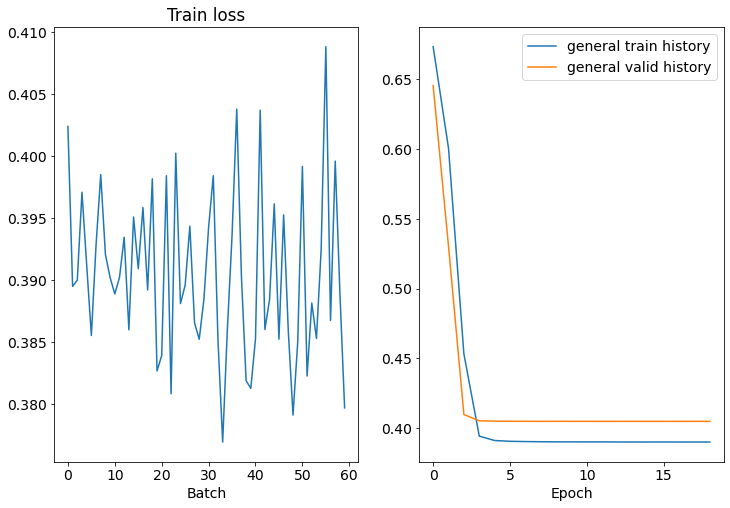

Epoch: 20 | Time: 0m 11s
	Train Loss: 0.390 | Train PPL:   1.477
	 Val. Loss: 0.405 |  Val. PPL:   1.499
Count: 245
Ref[-1]: два российских боксера были задержаны в москве при попытке забрать наркотики , при этом чемпион страны в весе до 81 кг георгий кушиташвили напал на сотрудника росгвардии и теперь может получить срок еще и за это .
Hyp[-1]: 2 февраля мир российского бокса шокировала новость о задержании двух членов сборной россии георгия кушиташвили и овика оганнисяна . боксеров скрутили сотрудники росгвардии , чей патруль заметил , как подозрительные молодые люди зашли в подъезд дома на фрунзенской набережной . « в ходе проверки документов мужчины вели себя агрессивно , не реагировали на законные требования стражей правопорядка , а один из них напал на сотрудника росгвардии , нанеся удар в лицо , — сообщила пресс-служба организации .
Ref[-2]: в кремле рассказали , что не получали никаких поздравительных посланий ко дню рождения владимира путина от дональда трампа и владимира зеле

In [292]:
model = SentenceTaggerRNN(vocab_size, use_novelty = False).to(device)
train_2(False, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
b = inference_summarunner(model, test_iterator, 3)
b_class_w_false.append(b)

In [293]:
# logits с порогом > 0
b = inference_summarunner_2(model, test_iterator, 0.001)
b_class_w_false_coeff_0.append(b)

Count: 227
Ref[-1]: киев может перейти к прямым закупкам российского газа , если на него будет установлена цена , привязанная к европейским тарифам . об этом заявил глава минэнерго украины алексей оржель . платить за газ « политическую цену » , то есть повышенную , он не готов . конфликт может быть решен президентами россии и украины в париже 9 декабря .
Hyp[-1]: если цена на газ будет привязана к европейскому индикатору , то украина может рассмотреть вариант прямых поставок газа из россии в европу . об этом заявил министр энергетики и защиты окружающей среды украины алексей оржель . « четыре года мы получаем цену на газ так : цена европы плюс транспортировка назад , поэтому у нас одна их наивысших цен » , — сказал министр . по его словам , есть четкая позиция украинской стороны в переговорах по газу . « мы говорим , что если мы с вами можем договариваться про прямые поставки , в комплексе , в пакете , то цена должна быть привязана к европейскому индикатору » , — уточнил украинский чин

In [294]:
# logits с лучшим эмпирически подобранным порогом 
b = inference_summarunner_2(model, test_iterator, .6)
b_class_w_false_coeff_best.append(b)

Count: 252
Ref[-1]: продюсер максим фадеев объявил о расторжении контрактов со всеми своими артистами . по его словам , все теперь уже бывшие представители лейбла malfa получили контент в « безвозмездное пользование » кроме двух музыкантов , имена которых он раскрывать не стал .
Hyp[-1]: музыкальный продюсер максим фадеев сообщил , что его лейбл malfa расторг контракты со всеми своими артистами . по словам 51-летнего композитора , решением продюсерского центра контент был отдан теперь уже бывшим представителям malfa в « безвозмездное пользование » — за исключением двух музыкантов , с которыми до сих пор идут судебные споры . по словам певицы , она неоднократно пыталась прекратить работать с продюсерским центром , но для фадеева была артисткой , « приносящей бабло » , и он был заинтересован в продолжении сотрудничества . кроме того , закирова заверила , что в лейбле « всем рулит » серябкина .
Ref[-2]: после ряда успешных проектов marvel studios , которые вышли под руководством кевина фа

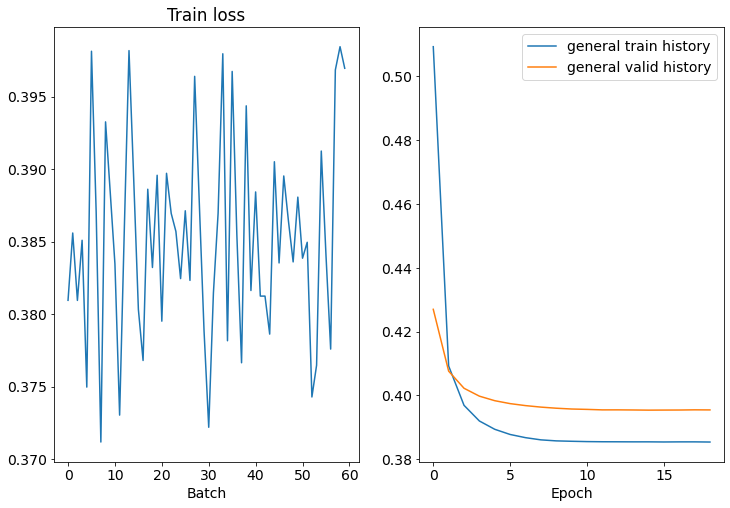

Epoch: 20 | Time: 0m 13s
	Train Loss: 0.385 | Train PPL:   1.470
	 Val. Loss: 0.395 |  Val. PPL:   1.485
Count: 250
Ref[-1]: украинская исполнительница maruv посвятила гневный пост в своем instagram некоторым представителям сми и хейтерам , которые обрушились на нее после победы в номинации « лучший артист по версии телеканала « mtv россия » в рамках ежегодной премии mtv eur о pe music awards . певица посоветовала им « научиться читать и проверять факты , прежде чем обливать грязью » .
Hyp[-1]: украинская певица maruv ( настоящее имя — анна корсун ) отреагировала на очередную « лавину хейта » в свой адрес , которая обрушилась на нее после победы в номинации « лучший артист по версии телеканала « mtv россия » в рамках ежегодной премии mtv eur о pe music awards . в своем instagram артистка написала большой эмоциональный пост , начав с того , что ей надоел « этот бесполезный срач и перекручивание фактов в сми » . в день церемонии награждения певица выложила в сторис своего блога несколько

In [295]:
model = SentenceTaggerRNN(vocab_size, use_novelty = True).to(device)
train_2(False, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
b = inference_summarunner(model, test_iterator, 3)
b_class_w_false.append(b)

In [296]:
# logits с порогом > 0
b = inference_summarunner_2(model, test_iterator, .001)
b_class_w_false_coeff_0.append(b)

Count: 256
Ref[-1]: падчерица бойца ufc уолта харриса энайа блэншард найдена мертвой . 19-летняя студентка пропала без вести в октябре , а накануне правоохранительные органы обнаружили останки человеческого тела , которые , как предполагается , принадлежат ей . по делу об убийстве задержаны двое подозреваемых .
Hyp[-1]: энайа блэншард , приемная дочь профессионального бойца смешанного стиля ( mma ) уолта харриса , найдена мертвой . как сообщает cbs , 25 ноября правоохранительные органы обнаружили останки человеческого тела в округе мейкон , штат джорджия , которые , по предварительным данным , принадлежат пропавшей девушке . « я могу подтвердить , что мы нашли человеческие останки , и у нас есть веские основания подозревать , что это блэншард » , — цитирует окружного прокурора брэндона хьюза wrbl news 3 .
Ref[-2]: военнослужащие всу уже не способны наступать и побеждать , сейчас они могут только терпеть поражения , считает бывший участник боевых действий в донбассе из германии . о том 

In [297]:
# logits с лучшим эмпирически подобранным порогом 
b = inference_summarunner_2(model, test_iterator, .0005)
b_class_w_false_coeff_best.append(b)

Count: 256
Ref[-1]: 75 лет назад генерал-изменник андрей власов провозгласил в праге манифест , обозначив такие цели , как свержение сталинской тирании и освобождение народов россии от большевистской системы . власовское движение оформилось в политическую организацию конр , которая имела собственные вооруженные силы , и позиционировалась в качестве полноправного союзника нацистской германии .
Hyp[-1]: 14 ноября 1944 года бывший генерал-лейтенант красной армии андрей власов , попавший в плен и перешедший на сторону нацистской германии в ходе второй мировой войны , провозгласил в праге манифест комитета освобождения народов россии ( конр ) . основным положением состоявшего из 14 пунктов программного документа являлось « свержение сталинской тирании , освобождение народов россии от большевистской системы и возвращение народам россии прав , завоеванных ими в народной революции 1917 года » . своей целью конр ставил прекращение войны и заключение почетного мира с германией , затем – « создан

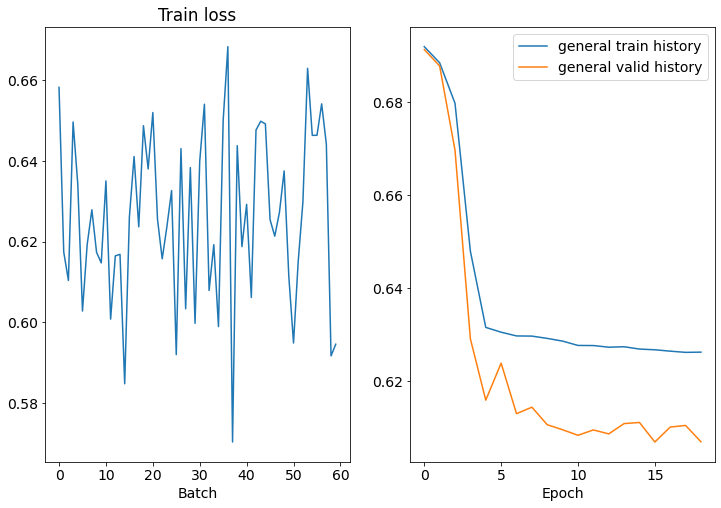

Epoch: 20 | Time: 0m 11s
	Train Loss: 0.626 | Train PPL:   1.870
	 Val. Loss: 0.610 |  Val. PPL:   1.840
Count: 256
Ref[-1]: сбу проводит обыски офисе медиа-группы « 1 + 1 » олигарха игоря коломойского , а также в квартирах нескольких журналистов . по словам правоохранителей , следственные действия связаны с уголовным делом о прослушивании совещания премьер-министра алексея гончарука , на котором глава правительства раскритиковал президента украины владимира зеленского .
Hyp[-1]: в киеве в одном из офисов медиа-группы « 1 + 1 » олигарха игоря коломойского сотрудники службы безопасности украины провели обыски . представитель спецслужбы елена гитлянская заверила , что следственные действия вызваны не работой телеканала , а его отдельными сотрудниками , которые на рабочем месте « создавали и хранили аудио файлы , полученные незаконным способом » . кроме того , ряд других сотрудников сми проверяется « на причастность к незаконному использованию специальных технических средств » .
Ref[-2]: 

In [298]:
model = SentenceTaggerRNN(vocab_size, use_novelty = False).to(device)
train_2(True, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
b = inference_summarunner(model, test_iterator, 3)
b_class_w_true.append(b)

In [299]:
# logits с порогом > 0
b = inference_summarunner_2(model, test_iterator, .001)
b_class_w_true_coeff_0.append(b)

Count: 254
Ref[-1]: россия второй год подряд занимает 43-е место в рейтинге конкурентоспособности мировых экономик . аналитики всемирного экономического форума отметили удачные меры властей по борьбе с инфляцией и внедрению новых технологий , но и эти достижения не позволили стране получить более престижную строчку . пока москва не решит проблему с плохим инвестиционный климатом и не прекратит показательные посадки крупных бизнесменов новых высот ей не видать , указывают эксперты .
Hyp[-1]: россия получила 43-строчку в индексе мировой конкурентоспособности , который ежегодно составляет всемирный экономический форум ( вэф ) . по сравнению с прошлым годом страна несколько увеличила свой общий балл с 65,6 до 66,7 . рост итоговой оценки обусловлен пока еще положительными показателями в маркоэкономики страны , указывают зарубежные эксперты . так , россия получила два дополнительных балла за снижения уровня инфляции до 3 % и преодоление рецессии . вдобавок стране дали 2,2 бала за свои « стра

In [300]:
# logits с лучшим эмпирически подобранным порогом 
b = inference_summarunner_2(model, test_iterator, .7)
b_class_w_true_coeff_best.append(b)

Count: 256
Ref[-1]: в четверг исполняется 65 лет кондолизе райс — одной из самых знаковых фигур американской политики администрации джорджа буша — младшего . специалист по ссср и россии , она пользовалась уважением в москве , но продвигала жесткую линию по включению украины и грузии в нато . выйдя в отставку , райс старается держаться подальше от белого дома , хотя в последнее время позволила себе критические высказывания о президенте сша дональде трампе .
Hyp[-1]: в детстве и юности 66-й госсекретарь сша кондолиза райс , которой в четверг исполняется 65 лет , занималась музыкой . ее любимым композитором был немецкий композитор иоганнес брамс , которого она называла « страстным , но без сентиментальности » .
Ref[-2]: для борьбы с с недобросовестными азс , недоливающими топливо , будут использоваться специальные приборы , а также проверки программного обеспечения . в этом вопросе росстандарт намерен использовать опыт , полученный в сфере регулирования работы игровых автоматов .
Hyp[-2]:

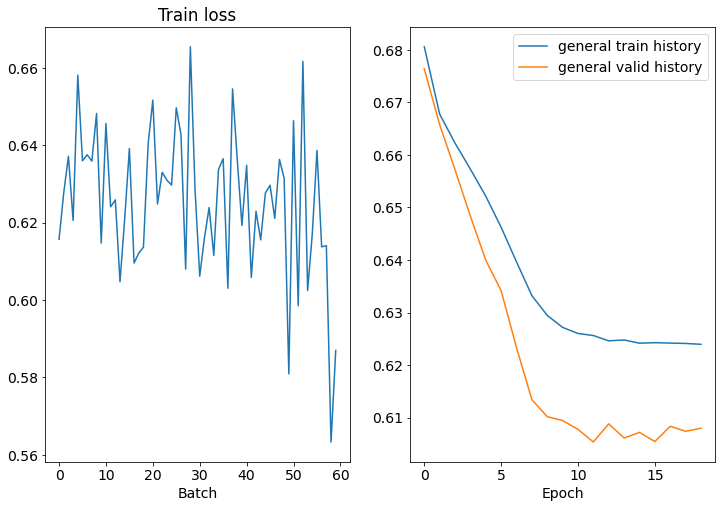

Epoch: 20 | Time: 0m 13s
	Train Loss: 0.624 | Train PPL:   1.867
	 Val. Loss: 0.606 |  Val. PPL:   1.833
Count: 256
Ref[-1]: на украине представили обновленные правила отбора на « евровидение » . в частности , согласно нововведениям , представителями страны на песенном конкурсе в будущем году смогут стать исключительно те артисты , которые не выступали в россии с 2014-го и не планируют делать это в ближайшее время .
Hyp[-1]: национальная общественная телерадиокомпания украины ( ноту ) представила обновленные правила отбора на « евровидение » . в пресс-релизе организации отмечается , что на главный песенный конкурс европы от украины в 2020 году смогут поехать только те артисты , которые не осуществляли концертной деятельности на территории россии с 2014-го , не планируют и не анонсируют ее вплоть до финала шоу , а также не въезжали в крым с территории рф . по словам председателя правления ноту зураба аласании , будущий представитель страны на « евровидении » должен быть « не только тала

In [301]:
model = SentenceTaggerRNN(vocab_size, use_novelty = True).to(device)
train_2(True, N_EPOCHS, CLIP)
model.load_state_dict(torch.load('best-val-model.pt'))
b = inference_summarunner(model, test_iterator, 3)
b_class_w_true.append(b)

In [302]:
# logits с порогом > 0
b = inference_summarunner_2(model, test_iterator, .001)
b_class_w_true_coeff_0.append(b)

Count: 256
Ref[-1]: протесты украинских шахтеров вынудили раду выделить дополнительные $ 40 млн угледобывающей промышленности . этих денег хватит на погашение текущих долгов , однако не за горами новые : объемы производства сокращаются , средств не хватает даже для освещения шахт , а уже добытый уголь никому не нужен и лежит на складах .
Hyp[-1]: ситуация с угледобывающей промышленностью на украине , где шахтеры вынуждены выходить на улицы , чтобы получить зарплату , остается весьма шаткой . сумма долгов горнякам составляет $ 47 млн . хотя в четверг депутаты рады поддержали законопроект о внесении изменений в госбюджет , чтобы выплатить шахтерами заработную плату , что будет дальше с шахтерами и государственными угледобывающими предприятиями — неизвестно .
Ref[-2]: накопительная часть пенсии не будет разморожена . по крайней мере до 2022 года включительно . это следует из подписанного президентом владимиром путиным закона . накопительная часть пенсии была заморожена еще в 2014 году и п

In [303]:
# logits с лучшим эмпирически подобранным порогом 
b = inference_summarunner_2(model, test_iterator, .35)
b_class_w_true_coeff_best.append(b)

Count: 256
Ref[-1]: у россии появился новый потенциальный покупатель истребителей пятого поколения су-57 , сообщают сми . журналисты обратили внимание , что государство мьянма испытывает потребность в них , поскольку мощности закупленных ранее су-30 может не хватить для оказания противодействия противнику .
Hyp[-1]: интерес к покупке российских истребителей пятого поколения су-57 проявила мьянма , сообщает журнал military watch . по данным издания , программа модернизации ввс государства предполагает закупку тяжелых истребителей .
Ref[-2]: нато оценит действия турции в сирии — соответствующая комиссия альянса создана в брюсселе . операция « источник мира » , которую проводит анкара против курдов , может стать настоящим испытанием военного блока на прочность , а среди самих стран-членов нато растут разногласия по самым разным поводам .
Hyp[-2]: в брюсселе создан кризисный штаб нато для оценки военной операции « источник мира » , которую проводит турция на севере сирии , пишет германская

# Таблицы значений BLEU с использованием novelty и без, а также c весами в CrossEntropyLoss и без

### Таблица без порога для логитов

In [304]:
import pandas as pd

data = {'' :  ['use_novelty=False', 
                   'use_novelty=True' ], 
        'use_class_weights=False': b_class_w_false, 
        'use_class_weights=True' :  b_class_w_true}
df =  pd.DataFrame(data)
df

,,use_class_weights=False,use_class_weights=True
0,use_novelty=False,0.415910,0.448336
1,use_novelty=True,0.420435,0.448336


Видим, что использование весов в CrossEntropyLoss повышает метрику.

### Таблица с порогом для логитов > 0

In [305]:
data = {'' :  ['use_novelty=False', 
                   'use_novelty=True' ], 
        'use_class_weights=False': b_class_w_false_coeff_0, 
        'use_class_weights=True' :  b_class_w_true_coeff_0}
df =  pd.DataFrame(data)
df

,,use_class_weights=False,use_class_weights=True
0,use_novelty=False,0.225641,0.242622
1,use_novelty=True,0.365048,0.370910


Может, я что-то сделала не так, но кажется, что порог > 0 не самый лучший вариант.

### Таблица с лучшим эмпирически подобранным порогом для логитов

In [306]:
data = {'' :  ['use_novelty=False', 
                   'use_novelty=True' ], 
        'use_class_weights=False': b_class_w_false_coeff_best, 
        'use_class_weights=True' :  b_class_w_true_coeff_best}
df =  pd.DataFrame(data)
df

,,use_class_weights=False,use_class_weights=True
0,use_novelty=False,0.443039,0.414116
1,use_novelty=True,0.365048,0.454896


У модели с весами и novelty удалось получить метрику 0.455 при пороге для логитов > 0.35.

## Вывод:

Удалось добиться BLEU = 0.455 у модели с весами в CrossEntropyLoss и novelty=True, при пороге для логитов > 0.35.

1. При выборе топ-5 моделей вместо топ-3 метрика на всех моделях падает.
2. При использовании порога для логитов > 0 метрика для всех моделей падает. 
3. Novelty незначительно влияет на результаты.